# -*-utf-8 -*- Tarea Transformers - Análisis de Sentimiento IMDB
Nombre: Gabriela Gómez Ibarra

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# ==================== CONFIGURACIÓN ====================

In [2]:
VOCAB_SIZE = 20000
MAX_LEN    = 200
EMB_DIM    = 128
BATCH      = 64
EPOCHS     = 20

# ==================== CARGA Y PREPROCESAMIENTO ====================

In [3]:
print("Cargando dataset IMDB...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding='pre', truncating='pre')
x_test  = pad_sequences(x_test,  maxlen=MAX_LEN, padding='pre', truncating='pre')

# Split de validación
VAL_SPLIT = 0.15
n_val = int(len(x_train) * VAL_SPLIT)
x_val, y_val = x_train[:n_val], y_train[:n_val]
x_trn, y_trn = x_train[n_val:], y_train[n_val:]

print(f"Train: {x_trn.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Cargando dataset IMDB...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (21250, 200), Val: (3750, 200), Test: (25000, 200)


# ==================== CAPAS PERSONALIZADAS ====================

In [4]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb   = layers.Embedding(max_len, embed_dim)
        self.max_len   = max_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# ==================== BLOQUE TRANSFORMER ====================

In [5]:
def transformer_block(x, use_multihead=True, num_heads=4, ff_dim=256, dropout=0.1):
    # Self-Attention (simple o multi-head)
    if use_multihead:
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=EMB_DIM // num_heads
        )(x, x)
    else:
        attn_output = layers.Attention()( [x, x] )

    attn_output = layers.Dropout(dropout)(attn_output)
    out1 = layers.Add()([x, attn_output])
    out1 = layers.LayerNormalization(epsilon=1e-6)(out1)

    # Feed-Forward
    ff = layers.Dense(ff_dim, activation="relu")(out1)
    ff = layers.Dense(EMB_DIM)(ff)
    ff = layers.Dropout(dropout)(ff)

    out2 = layers.Add()([out1, ff])
    out2 = layers.LayerNormalization(epsilon=1e-6)(out2)
    return out2

# ==================== MODELOS ====================

In [6]:
# Baseline simple
def build_baseline():
    inputs = layers.Input(shape=(MAX_LEN,), dtype="int32")
    x = layers.Embedding(VOCAB_SIZE, EMB_DIM)(inputs)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Transformer con Self-Attention simple
def build_transformer_selfatt():
    inputs = layers.Input(shape=(MAX_LEN,), dtype="int32")
    x = PositionalEmbedding(VOCAB_SIZE, EMB_DIM, MAX_LEN)(inputs)
    x = transformer_block(x, use_multihead=False)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# Transformer con Multi-Head Attention
def build_transformer_mha():
    inputs = layers.Input(shape=(MAX_LEN,), dtype="int32")
    x = PositionalEmbedding(VOCAB_SIZE, EMB_DIM, MAX_LEN)(inputs)
    x = transformer_block(x, use_multihead=True, num_heads=8)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# ==================== ENTRENAMIENTO ====================

In [7]:
baseline = build_baseline()
selfatt  = build_transformer_selfatt()
mha      = build_transformer_mha()

print("\n=== Entrenando Baseline ===")
hist_base = baseline.fit(x_trn, y_trn,
                         validation_data=(x_val, y_val),
                         epochs=15, batch_size=BATCH, verbose=2)

print("\n=== Entrenando Transformer Self-Attention ===")
hist_self = selfatt.fit(x_trn, y_trn,
                        validation_data=(x_val, y_val),
                        epochs=EPOCHS, batch_size=BATCH, verbose=2)

print("\n=== Entrenando Transformer Multi-Head Attention ===")
hist_mha = mha.fit(x_trn, y_trn,
                   validation_data=(x_val, y_val),
                   epochs=EPOCHS, batch_size=BATCH, verbose=2)


=== Entrenando Baseline ===
Epoch 1/15
333/333 - 3s - 10ms/step - accuracy: 0.7224 - loss: 0.5848 - val_accuracy: 0.8203 - val_loss: 0.4534
Epoch 2/15
333/333 - 1s - 3ms/step - accuracy: 0.8570 - loss: 0.3722 - val_accuracy: 0.8661 - val_loss: 0.3413
Epoch 3/15
333/333 - 1s - 3ms/step - accuracy: 0.8942 - loss: 0.2836 - val_accuracy: 0.8757 - val_loss: 0.3059
Epoch 4/15
333/333 - 1s - 4ms/step - accuracy: 0.9115 - loss: 0.2374 - val_accuracy: 0.8853 - val_loss: 0.2839
Epoch 5/15
333/333 - 1s - 4ms/step - accuracy: 0.9279 - loss: 0.2014 - val_accuracy: 0.8432 - val_loss: 0.3586
Epoch 6/15
333/333 - 1s - 3ms/step - accuracy: 0.9387 - loss: 0.1774 - val_accuracy: 0.8731 - val_loss: 0.2954
Epoch 7/15
333/333 - 1s - 3ms/step - accuracy: 0.9462 - loss: 0.1544 - val_accuracy: 0.8851 - val_loss: 0.2801
Epoch 8/15
333/333 - 1s - 3ms/step - accuracy: 0.9589 - loss: 0.1311 - val_accuracy: 0.8891 - val_loss: 0.2812
Epoch 9/15
333/333 - 1s - 3ms/step - accuracy: 0.9642 - loss: 0.1171 - val_accurac

# ==================== EVALUACIÓN FINAL ====================

In [8]:
test_base = baseline.evaluate(x_test, y_test, verbose=0)[1]
test_self = selfatt.evaluate(x_test, y_test, verbose=0)[1]
test_mha  = mha.evaluate(x_test, y_test, verbose=0)[1]

print("\n" + "="*50)
print("RESULTADOS FINALES EN TEST")
print("="*50)
print(f"Baseline                : {test_base:.4f}")
print(f"Transformer Self-Attn   : {test_self:.4f}")
print(f"Transformer Multi-Head  : {test_mha:.4f}")
print("="*50)


RESULTADOS FINALES EN TEST
Baseline                : 0.8451
Transformer Self-Attn   : 0.8419
Transformer Multi-Head  : 0.8305


# ==================== TABLA COMPARATIVA ====================

In [9]:
import pandas as pd
results = pd.DataFrame({
    "Modelo": ["Baseline", "Transformer Self-Attention", "Transformer Multi-Head"],
    "Test Accuracy": [test_base, test_self, test_mha]
})
print("\nTabla comparativa:")
display(results)


Tabla comparativa:


,Modelo,Test Accuracy
0,Baseline,0.84512
1,Transformer Self-Attention,0.84192
2,Transformer Multi-Head,0.83048


# ==================== GRÁFICAS ====================

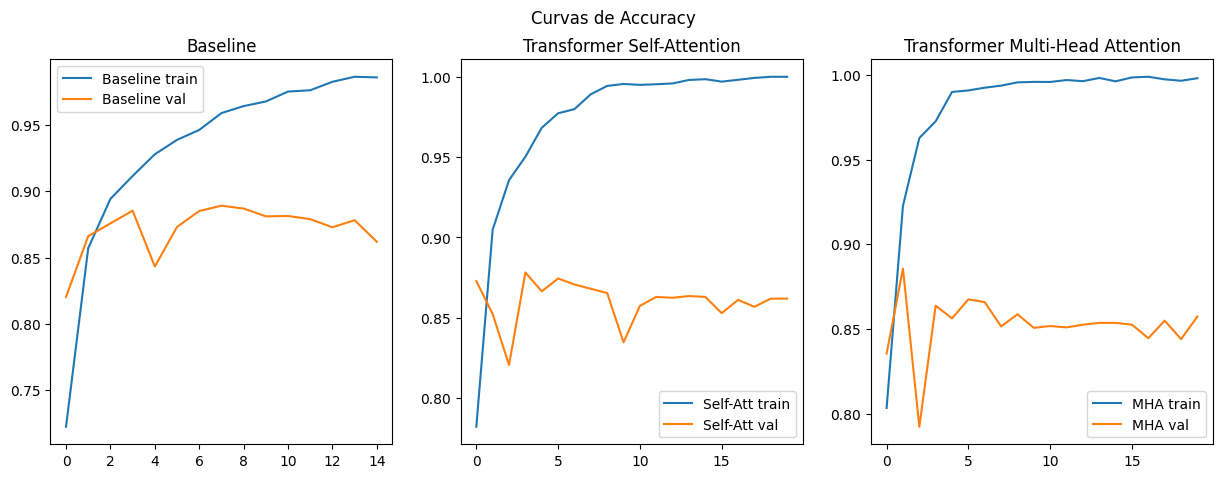

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(hist_base.history['accuracy'], label='Baseline train')
plt.plot(hist_base.history['val_accuracy'], label='Baseline val')
plt.title('Baseline')
plt.legend()

plt.subplot(1,3,2)
plt.plot(hist_self.history['accuracy'], label='Self-Att train')
plt.plot(hist_self.history['val_accuracy'], label='Self-Att val')
plt.title('Transformer Self-Attention')
plt.legend()

plt.subplot(1,3,3)
plt.plot(hist_mha.history['accuracy'], label='MHA train')
plt.plot(hist_mha.history['val_accuracy'], label='MHA val')
plt.title('Transformer Multi-Head Attention')
plt.legend()

plt.suptitle("Curvas de Accuracy")
plt.show()

### Respuesta a la pregunta de análisis

**¿Por qué la red Transformer requiere un “positional embedding” además del “embedding” usual de las redes recurrentes?**

Las redes recurrentes (RNN, LSTM, GRU) procesan la secuencia de forma secuencial y ordenada: en cada paso de tiempo t, el estado oculto ya contiene información de las posiciones 1 a t-1, por lo que el orden está implícito en la arquitectura.

En cambio, el mecanismo de atención de los Transformers es **permutación-invariante**: si cambiamos el orden de los tokens de entrada, los cálculos de atención producen exactamente el mismo resultado porque solo dependen del contenido de cada token, no de su posición.

Sin información posicional explícita, el modelo no podría distinguir entre frases como  
“el gato come al ratón” y “el ratón come al gato”.

Por eso se añade un **Positional Embedding** (o Positional Encoding) que inyecta información del orden absoluto (o relativo) de cada token. Al sumarlo al embedding semántico, el modelo puede aprender relaciones dependientes de la posición, algo esencial en lenguaje natural.

En resumen:  
Las RNN tienen orden por su naturaleza secuencial → no necesitan positional embedding.  
Los Transformers sacrifican ese orden por paralelismo extremo → necesitan positional embedding para recuperarlo.